In [1]:
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import nltk

Using TensorFlow backend.


In [2]:
# data=pd.read_csv("..\\Data\\model_training\\100000_samples_Reviews.csv")
data=pd.read_csv("..\\..\\Data\\model_training\\100000_samples_giga.csv", nrows=1000)
data[['Text','Summary']]

,Text,Summary
0,"this weekend 's group of eight summit in russia may be one of the last chances for the international community to revive stalled world trade talks , prime minister tony blair said wednesday .",britain 's blair says g-# summit may be one of last chances to revive wto talks
1,one of india 's biggest christian groups tuesday demanded revocation of a death sentence on a ##-year-old boy for insulting islam in pakistan .,indian christian group protests pakistani court ruling
2,"the internet boom is bringing sweeping demographic changes to silicon valley , according to an annual report card for the region , which shows that the number of nonwhite residents surpassed white...",influx of new immigrants found in silicon valley
3,india 's parliament reopened monday to consider the national budget as opposition parties planned a united attack on the government for failing to control hindu hard-liners who want to build a tem...,budget session of indian parliament opens on a stormy note
4,"taiwan 's small and medium-sized exporters that sign up for or renew <unk> website memberships will be offered discounted dun &amp; bradstreet -lrb- <unk> -rrb- accreditation , the taiwan external...",new <unk> members offered discounted <unk> logos
...,...,...
995,"a german pop star made a tearful courtroom apology monday for keeping her hiv status a secret from her sexual partners , before being confronted by an ex-lover who contracted the virus .",tearful german pop star confesses in hiv trial
996,portugal 's government is in talks with trade unions about introducing labor reforms it regards as vital to ease the country 's financial crisis .,portugal eyes labor reforms to ease economic woes
997,"hong kong shares ended modestly lower monday , with the blue-chip hang seng index down ##.## points , or #.# percent , to ##,###.## , after trading between ##,###.## and ##,###.## points during th...",hong kong shares end down jan. ##
998,"china 's military now possesses most of the sophisticated weapon systems found in the arsenals of developed western nations , the country 's defense minister said in comments published monday .",china says military arsenal comparable with west


In [3]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)
data

,Text,Summary
0,"this weekend 's group of eight summit in russia may be one of the last chances for the international community to revive stalled world trade talks , prime minister tony blair said wednesday .",britain 's blair says g-# summit may be one of last chances to revive wto talks
1,one of india 's biggest christian groups tuesday demanded revocation of a death sentence on a ##-year-old boy for insulting islam in pakistan .,indian christian group protests pakistani court ruling
2,"the internet boom is bringing sweeping demographic changes to silicon valley , according to an annual report card for the region , which shows that the number of nonwhite residents surpassed white...",influx of new immigrants found in silicon valley
3,india 's parliament reopened monday to consider the national budget as opposition parties planned a united attack on the government for failing to control hindu hard-liners who want to build a tem...,budget session of indian parliament opens on a stormy note
4,"taiwan 's small and medium-sized exporters that sign up for or renew <unk> website memberships will be offered discounted dun &amp; bradstreet -lrb- <unk> -rrb- accreditation , the taiwan external...",new <unk> members offered discounted <unk> logos
...,...,...
995,"a german pop star made a tearful courtroom apology monday for keeping her hiv status a secret from her sexual partners , before being confronted by an ex-lover who contracted the virus .",tearful german pop star confesses in hiv trial
996,portugal 's government is in talks with trade unions about introducing labor reforms it regards as vital to ease the country 's financial crisis .,portugal eyes labor reforms to ease economic woes
997,"hong kong shares ended modestly lower monday , with the blue-chip hang seng index down ##.## points , or #.# percent , to ##,###.## , after trading between ##,###.## and ##,###.## points during th...",hong kong shares end down jan. ##
998,"china 's military now possesses most of the sophisticated weapon systems found in the arsenals of developed western nations , the country 's defense minister said in comments published monday .",china says military arsenal comparable with west


In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [8]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: weekend group eight summit russia may one last chances international community revive stalled world trade talks prime minister tony blair said wednesday
Summary: _START_ britain blair says summit may be one of last chances to revive wto talks  _END_


Review: one india biggest christian groups tuesday demanded revocation death sentence year old boy insulting islam pakistan
Summary: _START_ indian christian group protests pakistani court ruling  _END_


Review: internet boom bringing sweeping demographic changes silicon valley according annual report card region shows number nonwhite residents surpassed whites first time
Summary: _START_ influx of new immigrants found in silicon valley  _END_


Review: india parliament reopened monday consider national budget opposition parties planned united attack government failing control hindu hard liners want build temple disputed site demolished mosque
Summary: _START_ budget session of indian parliament opens on stormy note  _END_


Revi

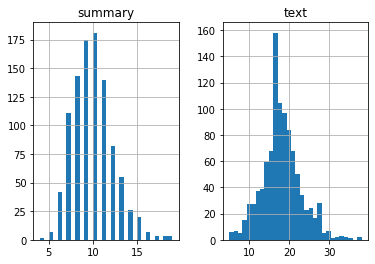

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
text_word_count = []
summary_word_count = []
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [13]:
max_len_text=30
max_len_summary=15
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [14]:
x_tr.iloc[0]

'blue chip share prices fell wall street week amid continued interest rate jitters recovered somewhat friday report showing modest job creation september'

In [15]:
y_tr.iloc[0]

'_START_ wall street slides on good economic news  _END_'

In [16]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)
print('x_tr[0] sequences:',x_tr[0])
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')
print('x_tr[0] padded sequences:', x_tr[0])

x_voc_size   =  len(x_tokenizer.word_index) +1
print('x_voc_size:',x_voc_size)

x_tr[0] sequences: [565, 935, 268, 88, 226, 452, 453, 41, 171, 454, 455, 203, 2324, 1364, 2325, 5, 172, 708, 1365, 936, 709, 566]
x_tr[0] padded sequences: [ 565  935  268   88  226  452  453   41  171  454  455  203 2324 1364
 2325    5  172  708 1365  936  709  566    0    0    0    0    0    0
    0    0]
x_voc_size: 5741


In [17]:
#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 
print('y_tr[0] sequences:', y_tr[0])

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')
print('y_tr[0] padded sequences:', y_tr[0])

y_voc_size  =   len(y_tokenizer.word_index) +1
print('y_voc_size:',y_voc_size)

y_tr[0] sequences: [2, 181, 250, 1006, 7, 564, 366, 45, 1]
y_tr[0] padded sequences: [   2  181  250 1006    7  564  366   45    1    0    0    0    0    0
    0]
y_voc_size: 3047


In [18]:
glove_dir='..\\..\\Data\\word_embeddings'
glove_dimension=200
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.'+str(glove_dimension)+'d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [19]:
from itertools import islice
list(islice(embeddings_index.items(), 1))

[('the',
  array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
          3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
          1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
         -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
          4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
          7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
          1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
         -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
         -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
          6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
         -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
          8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
          1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
          1.4379e-01, -1.2325

In [20]:
print(x_voc_size == len(x_tokenizer.word_index)+1)
word_index = x_tokenizer.word_index
print(len(word_index))
list(islice(word_index.items(), 4))

True
5740


[('said', 1), ('tuesday', 2), ('thursday', 3), ('wednesday', 4)]

In [21]:
# vocab_size_to_keep = 30000
# word_index_subset = list(islice(word_index.items(), vocab_size_to_keep))
embedding_matrix = np.zeros((len(word_index) + 1, glove_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(5741, 200)

In [22]:
# list(islice(embedding_matrix.items(), 4))
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13569   ,  0.14029001,  0.0041988 , ...,  0.0087948 ,
        -0.13017   , -0.25626001],
       [-0.51305997,  0.84114999, -0.29861999, ..., -0.34676   ,
        -0.12711   ,  0.070432  ],
       ...,
       [-0.68154001, -0.21574999, -0.23094   , ...,  0.40803   ,
        -0.27726999,  0.53696001],
       [-0.41299999,  0.66299999,  0.1503    , ...,  0.72470999,
         0.44069999,  0.16667999],
       [-0.27706   ,  0.11976   , -0.11074   , ..., -0.35699999,
        -0.057221  , -0.46768999]])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      1148200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 400), (N 961600      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

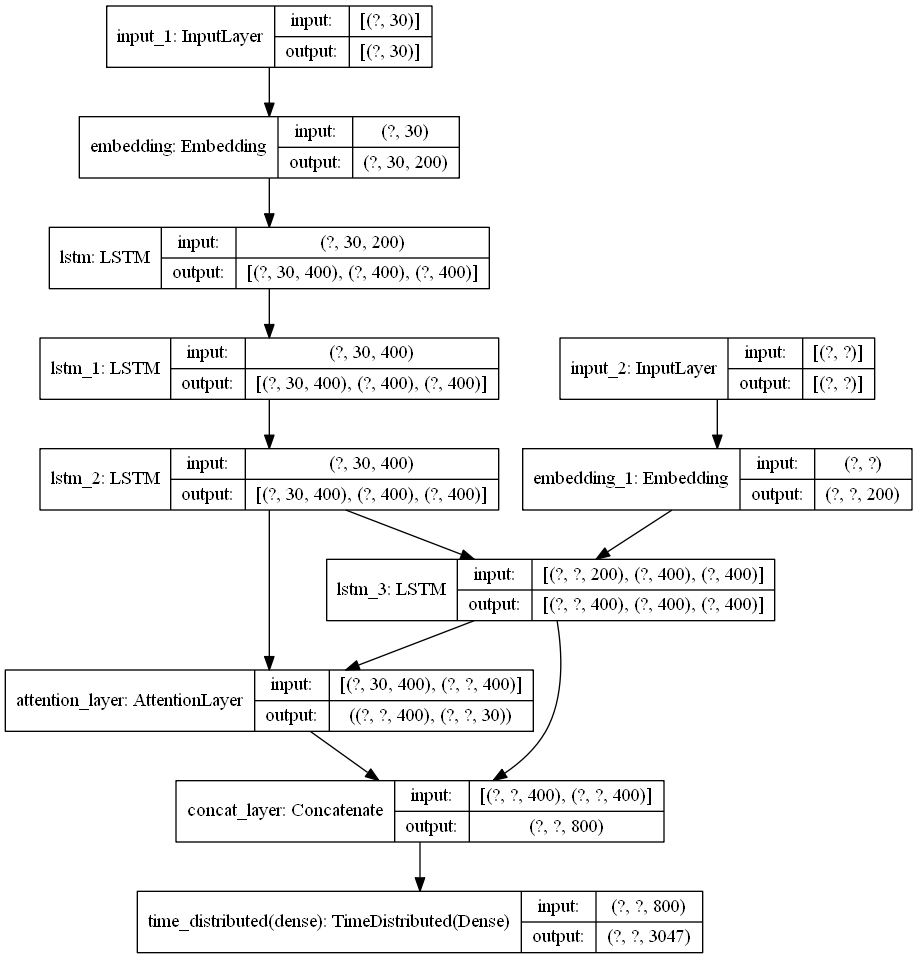

In [36]:
from attention import AttentionLayer
from keras import backend as K
K.clear_session()
latent_dim = 400

# Encoder 
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, glove_dimension, 
                    weights=[embedding_matrix],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, glove_dimension, 
                          weights=[embedding_matrix],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
# plot the model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## If the model needs to be trained again,

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=20,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]],
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 76s 84ms/sample - loss: 5.8590 - val_loss: 3.2924
Epoch 2/20
900/900 [==============================] - 46s 51ms/sample - loss: 4.5036 - val_loss: 3.2209
Epoch 3/20
900/900 [==============================] - 49s 55ms/sample - loss: 4.3933 - val_loss: 3.4276
Epoch 00003: early stopping


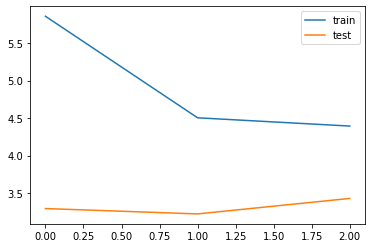

In [39]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

## Once trained well (100,000+ samples with many epochs), save model WEIGHTS into a .h5 file to use for later. H5 files are in the .gitignore due to their size. 

In [38]:
# serialize weights to HDF5
model.save_weights("model_gigaword.h5")
print("Saved model to disk")

Saved model to disk


In [40]:
model.load_weights('model.h5')

In [41]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

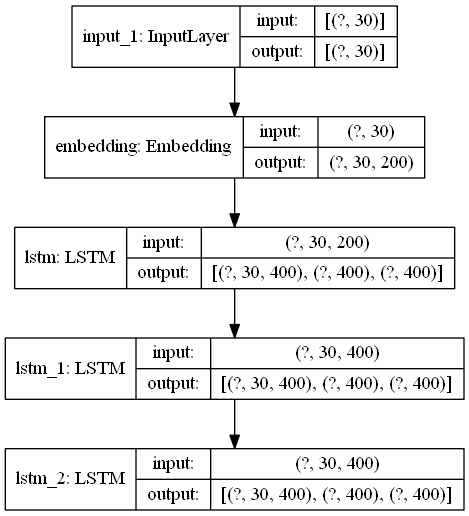

In [42]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
tf.keras.utils.plot_model(encoder_model, to_file='model.png', show_shapes=True)

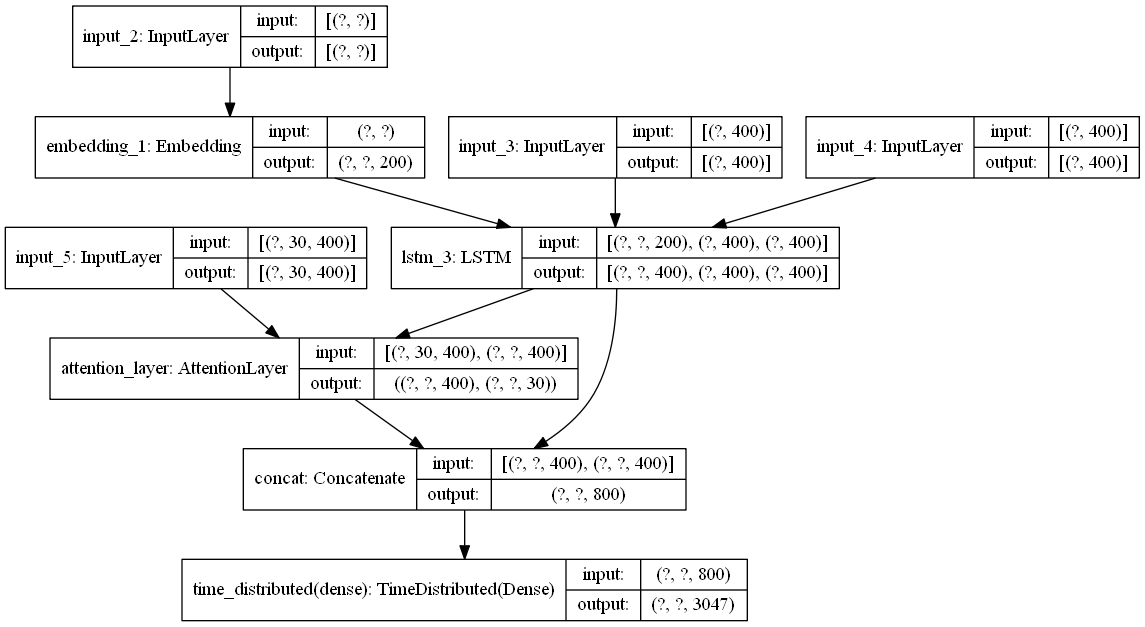

In [43]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])
tf.keras.utils.plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [44]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [45]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [46]:
for i in range(20):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: hopes ice hockey season could still tuesday even though national hockey league board rejected latest contract proposal hours talks 
Original summary: to final contract offer 
Predicted summary:  of of of in in


Review: bomb exploded outdoor concert belarus capital early friday morning injuring dozens three second device found later area according authorities 
Original summary: blast at injures dozens in 
Predicted summary:  of of of in in


Review: another opening day near red sox fans certain knows heat owners 
Original summary: opening 
Predicted summary:  of of of in in


Review: one thing certain democratic presidential john tap sen john running win points business community 
Original summary: plays better consumer than corporate leaders 
Predicted summary:  of of of in in


Review: cote ivoire requested united nations increase presence country additional unit peacekeepers burkina faso security ahead country presidential elections world body said tuesday 
Original summary:

# Rouge scores

In [47]:
from __future__ import division
from itertools import chain


def get_unigram_count(tokens):
    count_dict = dict()
    for t in tokens:
        if t in count_dict:
            count_dict[t] += 1
        else:
            count_dict[t] = 1

    return count_dict


class Rouge:
    beta = 1

    @staticmethod
    def my_lcs_grid(x, y):
        n = len(x)
        m = len(y)

        table = [[0 for i in range(m + 1)] for j in range(n + 1)]

        for j in range(m + 1):
            for i in range(n + 1):
                if i == 0 or j == 0:
                    cell = (0, 'e')
                elif x[i - 1] == y[j - 1]:
                    cell = (table[i - 1][j - 1][0] + 1, '\\')
                else:
                    over = table[i - 1][j][0]
                    left = table[i][j - 1][0]

                    if left < over:
                        cell = (over, '^')
                    else:
                        cell = (left, '<')

                table[i][j] = cell

        return table

    @staticmethod
    def my_lcs(x, y, mask_x):
        table = Rouge.my_lcs_grid(x, y)
        i = len(x)
        j = len(y)

        while i > 0 and j > 0:
            move = table[i][j][1]
            if move == '\\':
                mask_x[i - 1] = 1
                i -= 1
                j -= 1
            elif move == '^':
                i -= 1
            elif move == '<':
                j -= 1

        return mask_x

    @staticmethod
    def rouge_l(cand_sents, ref_sents):
        lcs_scores = 0.0
        cand_unigrams = get_unigram_count(chain(*cand_sents))
        ref_unigrams = get_unigram_count(chain(*ref_sents))
        for cand_sent in cand_sents:
            cand_token_mask = [0 for t in cand_sent]
            cand_len = len(cand_sent)
            for ref_sent in ref_sents:
                # aligns = []
                # Rouge.lcs(ref_sent, cand_sent, aligns)
                Rouge.my_lcs(cand_sent, ref_sent, cand_token_mask)

                # for i in aligns:
                #     ref_token_mask[i] = 1
            # lcs = []
            cur_lcs_score = 0.0
            for i in range(cand_len):
                if cand_token_mask[i]:
                    token = cand_sent[i]
                    if cand_unigrams[token] > 0 and ref_unigrams[token] > 0:
                        cand_unigrams[token] -= 1
                        ref_unigrams[token] -= 1
                        cur_lcs_score += 1

                        # lcs.append(token)

            # print ' '.join(lcs)

            lcs_scores += cur_lcs_score

        # print "lcs_scores: %d" % lcs_scores
        ref_words_count = sum(len(s) for s in ref_sents)
        # print "ref_words_count: %d" % ref_words_count
        cand_words_count = sum(len(s) for s in cand_sents)
        # print "cand_words_count: %d" % cand_words_count

        precision = lcs_scores / cand_words_count
        recall = lcs_scores / ref_words_count
        f_score = (1 + Rouge.beta ** 2) * precision * recall / (recall +
                                                                Rouge.beta ** 2 * precision + 1e-7) + 1e-6  # prevent underflow
        return precision, recall, f_score

In [ ]:
r = Rouge()

system_generated_summary = ogSum
manual_summmary = predSum

[precision, recall, f_score] = r.rouge_l([system_generated_summary], [manual_summmary])

print("Precision is :"+str(precision)+"\nRecall is :"+str(recall)+"\nF Score is :"+str(f_score))

sum_F=sum_F+f_score
avg_F=sum_F/count

print("Sum of ROUGE Score: ",sum_F)
print("Average ROUGE Score = ", avg_F)

print("Count: ",count)